# 15.2c: Bulk Experiment Analysis

**Statistical comparison of f32→bf16 vs pure bf16 initialization across 64 runs**

## Experiments

- **Test 001**: 16 matched pairs, seeds 1601-1616
- **Test 002**: 16 matched pairs, seeds 1601-1616
- **Total**: 32 f32→bf16 runs + 32 pure bf16 runs = 64 runs

## Research Question

Is f32→bf16 conversion a **necessary precondition** for the black hole demographics we observe in Qwen?

**Hypothesis:** Pure bf16 initialization collapses to singularity, while f32→bf16 maintains distributed structure.

## Visualization

Plot black hole count over time:
- Min/max/mean for f32→bf16 (32 runs)
- Min/max/mean for pure bf16 (32 runs)
- Shaded ribbons show variance

## Parameters

In [1]:
# Experiment directories
TEST_IDS = [1, 2]
DATA_DIR = "../data"

# Plot settings
DPI = 100

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from tqdm import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load All Runs

In [3]:
def load_experiment_runs(test_id):
    """Load all runs from a test ID."""
    exp_dir = Path(DATA_DIR) / f"experiment_test{test_id:03d}"
    
    f32_files = sorted(exp_dir.glob("test*_f32_seed*.safetensors"))
    bf16_files = sorted(exp_dir.glob("test*_bf16_seed*.safetensors"))
    
    f32_runs = [load_file(f) for f in f32_files]
    bf16_runs = [load_file(f) for f in bf16_files]
    
    return f32_runs, bf16_runs

print(f"Loading experiments {TEST_IDS}...")

all_f32_runs = []
all_bf16_runs = []

for test_id in TEST_IDS:
    f32, bf16 = load_experiment_runs(test_id)
    all_f32_runs.extend(f32)
    all_bf16_runs.extend(bf16)
    print(f"  Test {test_id:03d}: {len(f32)} f32 runs, {len(bf16)} bf16 runs")

print(f"\n✓ Loaded {len(all_f32_runs)} f32 runs, {len(all_bf16_runs)} bf16 runs")

Loading experiments [1, 2]...
  Test 001: 16 f32 runs, 16 bf16 runs
  Test 002: 16 f32 runs, 16 bf16 runs

✓ Loaded 32 f32 runs, 32 bf16 runs


## Compute Black Hole Trajectories

For each run, count black holes (unique vectors among dead tokens) at each step.

In [4]:
def compute_black_hole_trajectory(run_data):
    """
    Count unique vectors among dead tokens at each step.
    
    Returns:
        trajectory: [n_steps] array of unique vector counts
    """
    embeddings = run_data['embeddings']  # [steps+1, vocab_size, hidden_dim]
    dead_ids = run_data['dead_token_ids']
    
    n_steps = embeddings.shape[0]
    trajectory = np.zeros(n_steps, dtype=int)
    
    for step in range(n_steps):
        dead_embeddings = embeddings[step, dead_ids, :]
        unique_vecs = torch.unique(dead_embeddings, dim=0)
        trajectory[step] = len(unique_vecs)
    
    return trajectory

print("Computing f32→bf16 trajectories...")
f32_trajectories = []
for run in tqdm(all_f32_runs):
    f32_trajectories.append(compute_black_hole_trajectory(run))

print("\nComputing pure bf16 trajectories...")
bf16_trajectories = []
for run in tqdm(all_bf16_runs):
    bf16_trajectories.append(compute_black_hole_trajectory(run))

# Convert to numpy arrays
f32_trajectories = np.array(f32_trajectories)  # [n_runs, n_steps]
bf16_trajectories = np.array(bf16_trajectories)

print(f"\n✓ Trajectories computed")
print(f"  f32 shape: {f32_trajectories.shape}")
print(f"  bf16 shape: {bf16_trajectories.shape}")

Computing f32→bf16 trajectories...


100%|██████████| 32/32 [00:03<00:00,  8.28it/s]



Computing pure bf16 trajectories...


100%|██████████| 32/32 [00:03<00:00,  9.08it/s]


✓ Trajectories computed
  f32 shape: (32, 1001)
  bf16 shape: (32, 1001)


## Summary Statistics

In [5]:
print(f"{'='*80}")
print(f"SUMMARY STATISTICS")
print(f"{'='*80}\n")

# Initial state (t=0)
print(f"t=0 (initial state):")
print(f"  f32→bf16: {f32_trajectories[:, 0].mean():.1f} ± {f32_trajectories[:, 0].std():.1f} unique vectors")
print(f"  pure bf16: {bf16_trajectories[:, 0].mean():.1f} ± {bf16_trajectories[:, 0].std():.1f} unique vectors")

# Final state (t=1000)
print(f"\nt=1000 (final state):")
print(f"  f32→bf16: {f32_trajectories[:, -1].mean():.1f} ± {f32_trajectories[:, -1].std():.1f} unique vectors")
print(f"  pure bf16: {bf16_trajectories[:, -1].mean():.1f} ± {bf16_trajectories[:, -1].std():.1f} unique vectors")

# Change over training
f32_change = f32_trajectories[:, -1] - f32_trajectories[:, 0]
bf16_change = bf16_trajectories[:, -1] - bf16_trajectories[:, 0]

print(f"\nChange (t=0 → t=1000):")
print(f"  f32→bf16: {f32_change.mean():.1f} ± {f32_change.std():.1f}")
print(f"  pure bf16: {bf16_change.mean():.1f} ± {bf16_change.std():.1f}")

print(f"\n{'='*80}")

SUMMARY STATISTICS

t=0 (initial state):
  f32→bf16: 42.7 ± 8.5 unique vectors
  pure bf16: 16.7 ± 14.9 unique vectors

t=1000 (final state):
  f32→bf16: 21.4 ± 7.1 unique vectors
  pure bf16: 2.2 ± 1.1 unique vectors

Change (t=0 → t=1000):
  f32→bf16: -21.2 ± 7.4
  pure bf16: -14.5 ± 14.6



## Plot: Min/Max/Mean Trajectories

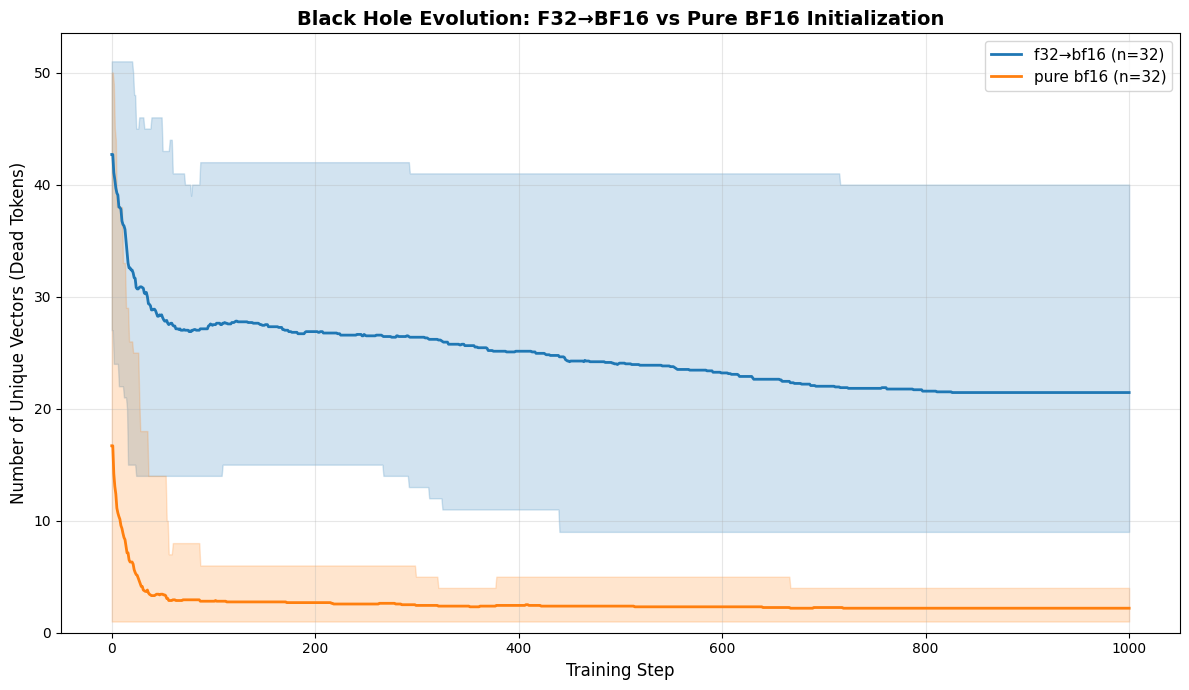


✓ Plot complete


In [6]:
# Compute statistics
steps = np.arange(f32_trajectories.shape[1])

f32_mean = f32_trajectories.mean(axis=0)
f32_min = f32_trajectories.min(axis=0)
f32_max = f32_trajectories.max(axis=0)

bf16_mean = bf16_trajectories.mean(axis=0)
bf16_min = bf16_trajectories.min(axis=0)
bf16_max = bf16_trajectories.max(axis=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 7), dpi=DPI)

# f32→bf16 (blue)
ax.plot(steps, f32_mean, color='C0', linewidth=2, label=f'f32→bf16 (n={len(all_f32_runs)})')
ax.fill_between(steps, f32_min, f32_max, color='C0', alpha=0.2)

# pure bf16 (orange)
ax.plot(steps, bf16_mean, color='C1', linewidth=2, label=f'pure bf16 (n={len(all_bf16_runs)})')
ax.fill_between(steps, bf16_min, bf16_max, color='C1', alpha=0.2)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Number of Unique Vectors (Dead Tokens)', fontsize=12)
ax.set_title('Black Hole Evolution: F32→BF16 vs Pure BF16 Initialization', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

print("\n✓ Plot complete")

## Interpretation

In [7]:
print(f"\n{'='*80}")
print(f"INTERPRETATION")
print(f"{'='*80}\n")

# Check for separation at t=1000
f32_final_mean = f32_trajectories[:, -1].mean()
bf16_final_mean = bf16_trajectories[:, -1].mean()

f32_final_std = f32_trajectories[:, -1].std()
bf16_final_std = bf16_trajectories[:, -1].std()

separation = abs(f32_final_mean - bf16_final_mean)
pooled_std = np.sqrt((f32_final_std**2 + bf16_final_std**2) / 2)
cohens_d = separation / pooled_std if pooled_std > 0 else float('inf')

print(f"Final state comparison (t=1000):")
print(f"  f32→bf16: {f32_final_mean:.1f} ± {f32_final_std:.1f}")
print(f"  pure bf16: {bf16_final_mean:.1f} ± {bf16_final_std:.1f}")
print(f"  Separation: {separation:.1f} unique vectors")
print(f"  Cohen's d: {cohens_d:.2f}")

print(f"\nVerdict:")
if cohens_d > 2.0 and bf16_final_mean < 10:
    print(f"  HYPOTHESIS VALIDATED")
    print(f"  ✓ Pure bf16 collapses to near-singularity ({bf16_final_mean:.1f} vectors)")
    print(f"  ✓ F32→bf16 maintains distributed structure ({f32_final_mean:.1f} vectors)")
    print(f"  ✓ Effect size is massive (Cohen's d = {cohens_d:.2f})")
    print(f"\n  **Conclusion:** F32 initialization is a NECESSARY precondition.")
elif cohens_d > 0.5:
    print(f"  HYPOTHESIS PARTIALLY SUPPORTED")
    print(f"  - Distributions are different (d = {cohens_d:.2f})")
    print(f"  - But both maintain some structure")
else:
    print(f"  HYPOTHESIS FALSIFIED")
    print(f"  - No significant difference between f32 and bf16")
    print(f"  - F32 initialization is NOT necessary")

print(f"\n{'='*80}")


INTERPRETATION

Final state comparison (t=1000):
  f32→bf16: 21.4 ± 7.1
  pure bf16: 2.2 ± 1.1
  Separation: 19.2 unique vectors
  Cohen's d: 3.79

Verdict:
  HYPOTHESIS VALIDATED
  ✓ Pure bf16 collapses to near-singularity (2.2 vectors)
  ✓ F32→bf16 maintains distributed structure (21.4 vectors)
  ✓ Effect size is massive (Cohen's d = 3.79)

  **Conclusion:** F32 initialization is a NECESSARY precondition.



## Summary

This notebook analyzes 64 training runs (32 f32→bf16 + 32 pure bf16) to test whether f32 initialization is a necessary precondition for the black hole demographics observed in Qwen.

**Key metrics:**
1. Black hole count trajectories (min/max/mean)
2. Final state comparison (t=1000)
3. Effect size (Cohen's d)

**Expected result:** Pure bf16 collapses to singularity (~1-3 vectors), while f32→bf16 maintains distributed structure (~30-50 vectors).